In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

In [3]:
prices = pd.read_csv("./factors/china/close_price.csv", index_col=0, parse_dates=True)["2000":]
pe = pd.read_csv("./factors/china/pe.csv", index_col=0, parse_dates=True)["2000":]

prices, pe = pqr.utils.replace_with_nan(prices, pe, to_replace=0)
prices, pe = pqr.utils.align(prices, pe)

# Формируем бенчмарк

In [4]:
benchmark = pqr.universe_as_benchmark(prices)

# Перебор параметров

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


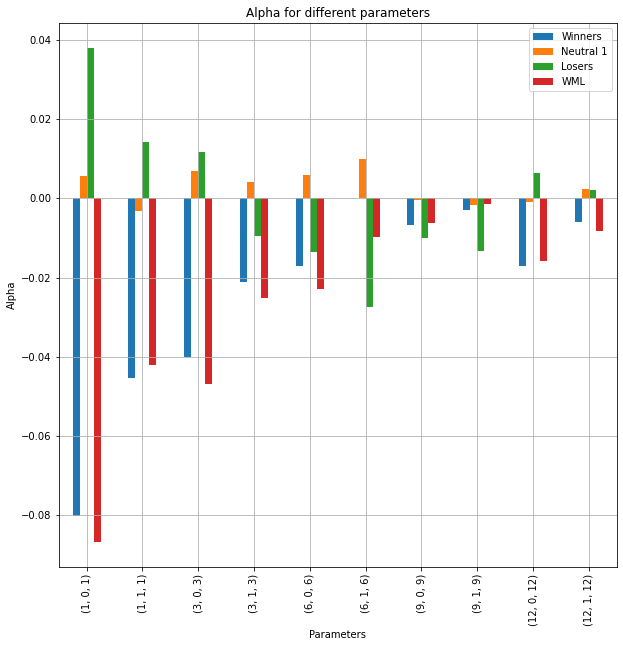

In [5]:
def dynamic_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.look_back_pct_change, period=looking),
        pqr.utils.partial(pqr.lag, period=lag),
        pqr.utils.partial(pqr.hold, period=holding),
    )


transforms_grid_mom = {
    "(1, 0, 1)": dynamic_transform_factory(1, 0, 1),
    "(1, 1, 1)": dynamic_transform_factory(1, 1, 1),
    "(3, 0, 3)": dynamic_transform_factory(3, 0, 3),
    "(3, 1, 3)": dynamic_transform_factory(3, 1, 3),
    "(6, 0, 6)": dynamic_transform_factory(6, 0, 6),
    "(6, 1, 6)": dynamic_transform_factory(6, 1, 6),
    "(9, 0, 9)": dynamic_transform_factory(9, 0, 9),
    "(9, 1, 9)": dynamic_transform_factory(9, 1, 9),
    "(12, 0, 12)": dynamic_transform_factory(12, 0, 12),
    "(12, 1, 12)": dynamic_transform_factory(12, 1, 12),
}

results = pqr.grid_search_factor_portfolios(
    prices=prices,
    strategies=list(reversed(pqr.split_quantiles(3))),
    factor=prices,
    transforms=transforms_grid_mom,
    metric=pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
    ),
    add_wml=True,
).plot.bar(figsize=(10, 10))

plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha")
plt.grid();

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


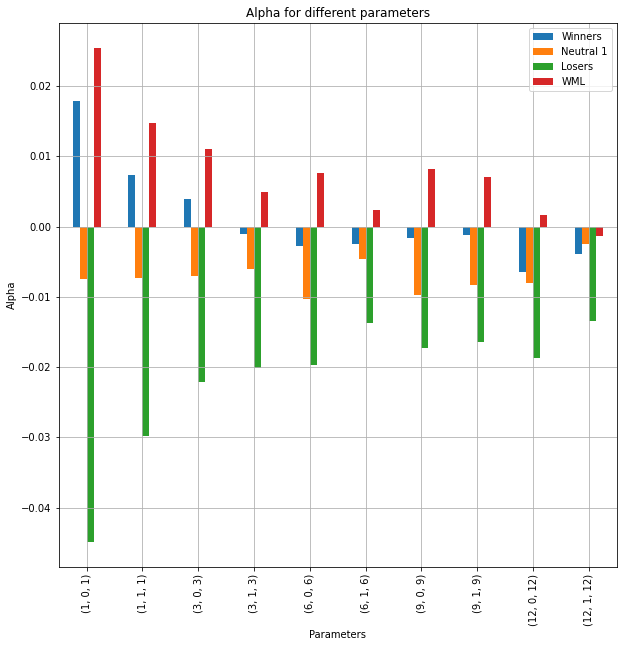

In [6]:
def mean_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.look_back_mean, period=looking),
        pqr.utils.partial(pqr.lag, period=lag),
        pqr.utils.partial(pqr.hold, period=holding),
    )


transforms_grid_value = {
    "(1, 0, 1)": mean_transform_factory(1, 0, 1),
    "(1, 1, 1)": mean_transform_factory(1, 1, 1),
    "(3, 0, 3)": mean_transform_factory(3, 0, 3),
    "(3, 1, 3)": mean_transform_factory(3, 1, 3),
    "(6, 0, 6)": mean_transform_factory(6, 0, 6),
    "(6, 1, 6)": mean_transform_factory(6, 1, 6),
    "(9, 0, 9)": mean_transform_factory(9, 0, 9),
    "(9, 1, 9)": mean_transform_factory(9, 1, 9),
    "(12, 0, 12)": mean_transform_factory(12, 0, 12),
    "(12, 1, 12)": mean_transform_factory(12, 1, 12),
}

results = pqr.grid_search_factor_portfolios(
    prices=prices,
    strategies=pqr.split_quantiles(3),
    factor=pe,
    transforms=transforms_grid_value,
    metric=pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
    ),
    add_wml=True,
).plot.bar(figsize=(10, 10))

plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha")
plt.grid();

По альфе лучшей моментум стратегией с точки зрения WML-портфеля оказалась стратегия (6, 1, 6), при этом среди value-стратегий, которые в основном были убыточны, единственной прибыльной оказалась стратегия (9, 0, 9). Можно утверждать, что на рынке Китая среднесрочные стратегии работают лучше. Сравним их между собой.

In [7]:
best_mom = dynamic_transform_factory(9, 1, 9)(prices)
best_value = mean_transform_factory(1, 0, 1)(pe)

portfolios_mom = pqr.backtest_factor_portfolios(
    factor=best_mom,
    prices=prices,
    strategies=pqr.split_quantiles(3),
    add_wml=True,
)
portfolios_value = pqr.backtest_factor_portfolios(
    factor=best_value,
    prices=prices,
    strategies=pqr.split_quantiles(3),
    add_wml=True,
)

# Ликбез по аналитике и дашбордам

Дашборд по сути показывает нам основные метрики. При этом у нас есть 2 вида метрик: числовые и time-series. Числовая метрика очевидно возвращает просто число, а ts-метрика - временной ряд. Отсюда и различия в том, как мы их можем отображать: числовые можем показать табличкой, а ts-метрики - графиком. Собирать таблицы и рисовать графики мы можем и руками, но это муторная и бесполезная рутина, потому что в библиотеке есть для этого функции. 

Для числовых метрик - `pqr.metrics.show_table`, которая принимает на вход список портфелей и словарь с метриками, где ключ это имя метрики, а значение - функция, которая при применении к портфелю выдает число. При этом метрика может требовать не только портфель, но и дополнительные обязательные параметры (например, для расчета альфы надо еще и бенчмарк знать), поэтому мы вынуждены пользоваться `pqr.utils.partial`, чтобы фиксировать эти "гиперпараметров".

Для ts-метрик - `pqr.metrics.plot_chart`. Логика там точно такая же - принимаем на вход список портфелей и словарь с метриками, опять же фиксируем "гиперпараметры" через `pqr.utils.partial`. При этом в саму функцию мы можем передать еще бенчмарк. В таком случае мы попробуем посчитать метрики для бенчмарка в том числе, и если получится, то метрика для бенчмарка тоже будет выведена на экран. Также можем передать как keyword-аргументы аргументы для функции `plt.figure`, например, чтобы поменять размер графика.

Попробуем теорию на практике.

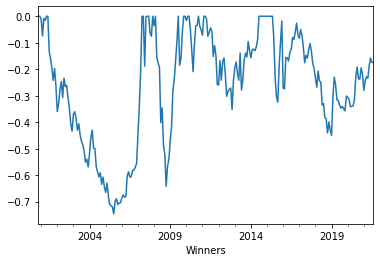

In [8]:
# нарисуем underwater график, который по сути просто считает просадку портфеля во времени
pqr.metrics.drawdown(portfolios_mom[0]).plot();

Получилось неплохо, если дописать еще 5-10 строчек, можно получить красивый график, но если захотим отобразить сразу несколько портфелей для сравнения, то надо добавить еще цикл, внимательно проследить за тем, чтобы не зажевало исходную точку. Если надо добавить бенчмарк, то надо проследить, чтобы бенчмарк начинался с начала нашего инвестирования и т.д. 

Чтобы это все не делать руками, воспользуемся библиотекой.

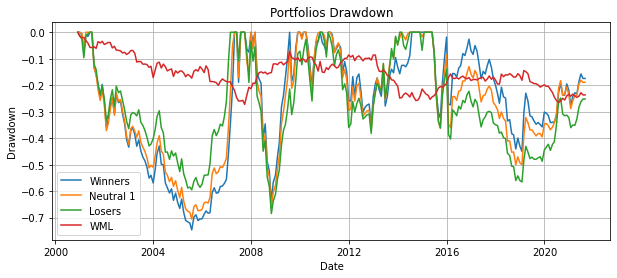

In [9]:
pqr.metrics.plot_chart(
    portfolios_mom,
    metrics={
        "Drawdown": pqr.metrics.drawdown
    },
    figsize=(10, 4),
)

Теперь займемся таблицей.

In [10]:
pqr.metrics.show_table(
    portfolios_value,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.30*** (2.47),1.15** (2.12),0.94* (1.59),0.15 (0.94)
"Monthly Volatility, %",8.45,8.72,9.49,2.58
"Maximum Drawdown, %",-66.48,-68.01,-75.99,-42.62
Sharpe Ratio,0.53,0.46,0.34,0.20
"Mean Excess Return, %",0.60,-1.19,-3.67,-13.14
"Alpha, %",1.78 (1.09),-0.75 (-0.72),-4.49*** (-3.80),2.54 (1.33)
Beta,0.92,0.97,1.05,-0.05


In [11]:
dd_chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Drawdown": pqr.metrics.drawdown
    },
    figsize=(10, 4),
)

comp_chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)

dashboard = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[dd_chart, table, comp_chart]
)

Все готово: отобразим результаты по лучшим стратегиям.

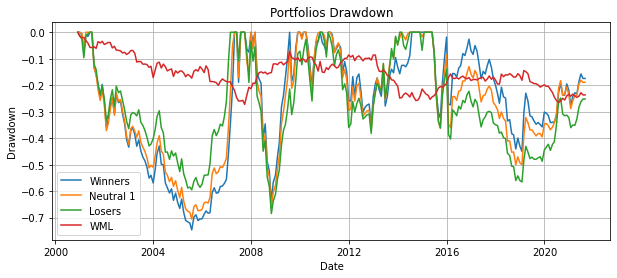

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.05** (1.79),1.14** (1.98),1.06** (1.93),-0.09 (-0.91)
"Monthly Volatility, %",9.25,9.12,8.71,1.65
"Maximum Drawdown, %",-74.63,-70.56,-68.45,-27.26
Sharpe Ratio,0.39,0.43,0.42,-0.20
"Mean Excess Return, %",-1.15,-0.02,-0.96,-14.87
"Alpha, %",-1.34 (-1.04),-0.17 (-0.22),-0.31 (-0.24),-1.18 (-0.93)
Beta,1.01,1.01,0.95,0.00


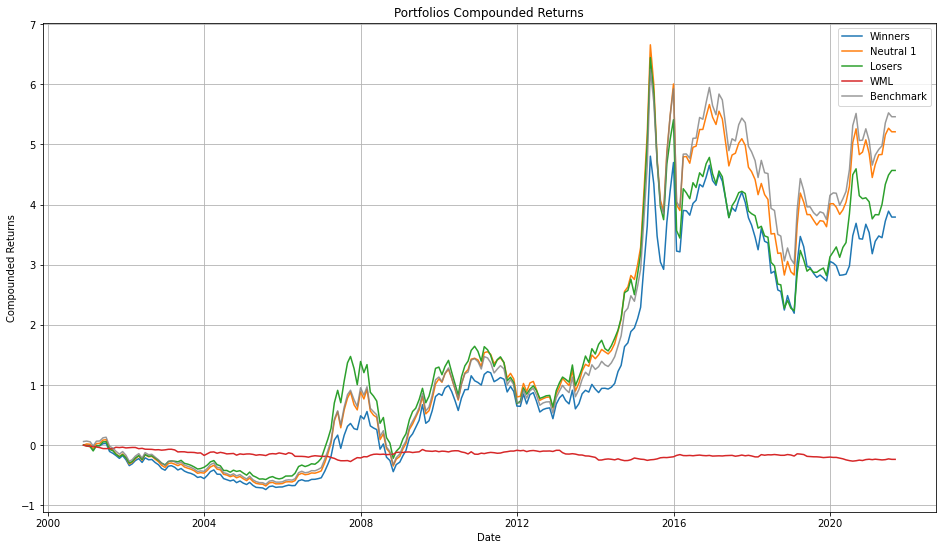

In [12]:
dashboard(portfolios_mom)

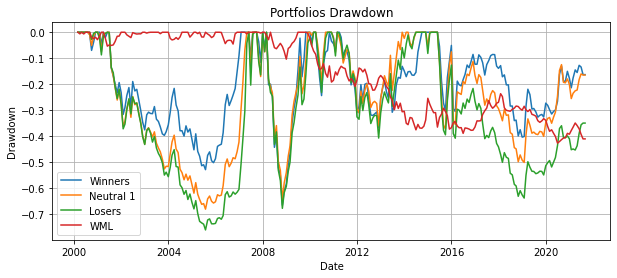

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.30*** (2.47),1.15** (2.12),0.94* (1.59),0.15 (0.94)
"Monthly Volatility, %",8.45,8.72,9.49,2.58
"Maximum Drawdown, %",-66.48,-68.01,-75.99,-42.62
Sharpe Ratio,0.53,0.46,0.34,0.20
"Mean Excess Return, %",0.60,-1.19,-3.67,-13.14
"Alpha, %",1.78 (1.09),-0.75 (-0.72),-4.49*** (-3.80),2.54 (1.33)
Beta,0.92,0.97,1.05,-0.05


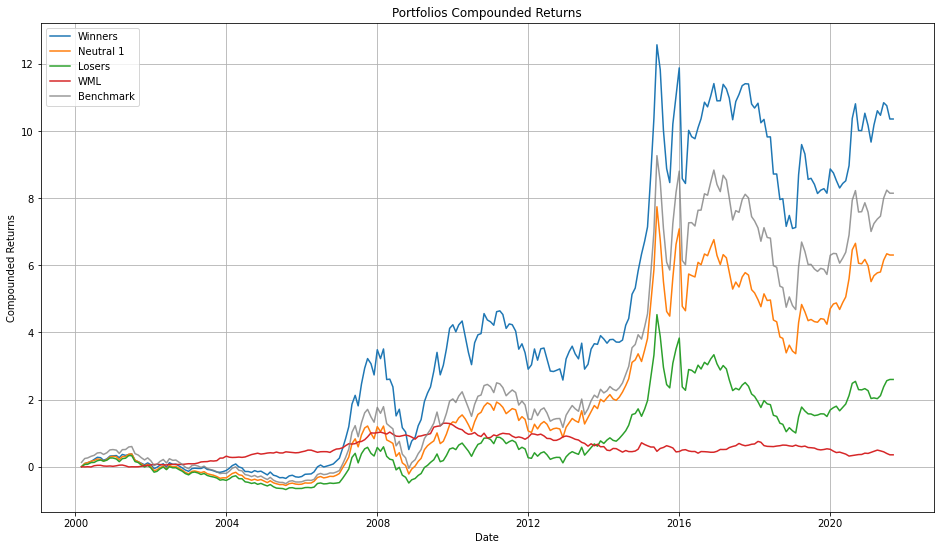

In [13]:
dashboard(portfolios_value)